In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py

/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/songzitao/anaconda3/envs/py36/lib

In [2]:
from environment.portfolio import PortfolioEnv

In [3]:
eps=1e-8

In [4]:
abbreviations = ['AAPL.O',
                 'ADBE.O',
                 'AMZN.O',
                 'DIS.N',
                 'GOOGL.O',
                 'JNJ.N',
                 'JPM.N',
                 'MSFT.O',
                 'NFLX.O',
                 'PG.N']

In [5]:
with h5py.File('./Data/history_stock_price.h5','r') as f:
    history_stock_price = f['stock_price'][...]
    timestamp = [s.decode('utf-8') for s in f['timestamp']]
    abbreviations = [s.decode('utf-8') for s in f['abbreviations']]
    features = [s.decode('utf-8') for s in f['features']]

In [6]:
env = PortfolioEnv(history=history_stock_price,abbreviation=abbreviations,timestamp=timestamp,steps=3000)

In [7]:
obs, ground_truth_obs = env.reset()

Start date: 2006-04-25


# Random Strategy

In [8]:
done = False
while not done:
    observation, onestep_r, done, info = env.step(np.random.rand(11))

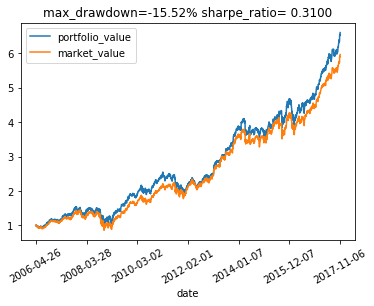

In [9]:
env.render()

In [ ]:
a = [1,2,3,4]

In [ ]:
a[-3:]

# DDPG

In [7]:
tf.reset_default_graph()

In [8]:
from model.ddpg.stockactor import StockActor
from model.ddpg.stockcritic import StockCritic
from model.ddpg.ddpg import DDPG
from model.core.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

In [9]:
import json
with open('configs/ddpg_default.json') as f:
    config = json.load(f)

In [10]:
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(config['input']['asset_number']+1))

In [11]:
sess = tf.Session()
stockactor = StockActor(sess, config, action_bound=1)
stockcritic = StockCritic(sess, config, num_actor_vars=stockactor.get_num_trainable_vars())


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [12]:
myddpg = DDPG(env,sess,stockactor,critic=stockcritic,
              actor_noise=actor_noise, config=config)

In [13]:
myddpg.initialize(load_weights=False)  # change to True to load weights

Build model from scratch



In [14]:
myddpg.train()


Start date: 2005-12-01


KeyboardInterrupt: 

# Testing

In [ ]:
pre_obs, ground_truth_obs = env.reset()
w = myddpg.predict(np.expand_dims(pre_obs,axis=0)).squeeze(axis=0)
for i in range(1000):
    obs, onestep_r, done, info = env.step(w)
    w = myddpg.predict(np.expand_dims(obs,axis=0)).squeeze(axis=0)

In [ ]:
env.render()